### Plot evolution of TNG and Chempy

In [49]:
%pylab inline
# Import solar abundances
import os
FS=16
os.chdir('/home/oliverphilcox/ChempyMulti/')
tng=np.load("/mnt/store1/oliverphilcox/ChempyMultiData/TNG/TNG_Mock_Data_Full_v4.npz")

Populating the interactive namespace from numpy and matplotlib


/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['uniform', 'gamma', 'norm']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## TNG only plot (see main plot below)

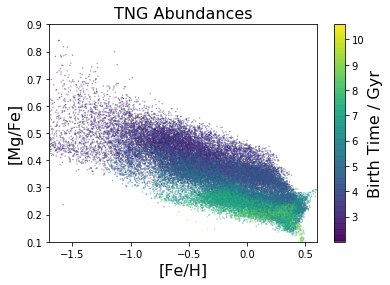

In [22]:
MgFeTNG=tng.f.true_abuns[:,3]
HeFeTNG=tng.f.true_abuns[:,2]
FeHTNG=tng.f.true_abuns[:,1]
timesTNG=tng.f.true_time
massesTNG = tng.f.particle_masses
plt.scatter(FeHTNG,MgFeTNG,alpha=0.8,s=0.1,c=timesTNG)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('TNG Abundances',fontsize=FS);
plt.xlim([-1.7,0.6]);plt.ylim([0.1,0.9]);

In [41]:
from scipy.special import gamma
SFR_peak=10.**0.55
def SFR(t,k=2,theta=SFR_peak):
    return 1./(gamma(k)*theta**k)*t**(k-1)*np.exp(-t/theta)

t_grid = np.linspace(1.,13.8,100000)
sfr_grid = SFR(t_grid)/np.sum(SFR(t_grid))
t_samples = np.random.choice(t_grid,size=10000,p=sfr_grid)

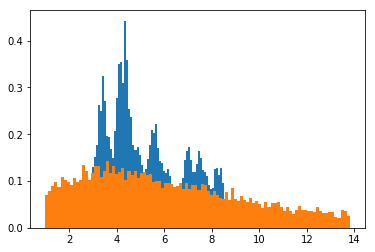

In [43]:
plt.hist(timesTNG,bins=100,density=True);
plt.hist(t_samples,bins=100,density=True);

### Make some Chempy data:

In [44]:
from Chempy.parameter import ModelParameters
a=ModelParameters()
import multiprocessing as mp
import numpy as np
import tqdm, time
from scipy.stats import norm,uniform
from Chempy.cem_function import single_timestep_chempy

N_samples = 1000

sampled_tng_times = np.random.choice(timesTNG[timesTNG>1.],size=N_samples,replace=True,p=massesTNG/np.sum(massesTNG))
widths = np.asarray([0.,0.,0.3,0.1,0.1])#,0.1,0.])
priors = [-2.3,-2.89,-0.3,0.55,0.5]#,1.5,0.]
all_params=np.zeros([N_samples,len(priors)+1])
for i in range(len(all_params)):
    while all_params[i,3]<0.29402: # to avoid SFR errors
        all_params[i,:-1]=norm.rvs(loc=priors,scale=widths)
    all_params[i,-1]=t_samples[i]#uniform.rvs(loc=1.0,scale=12.8) # sampled_tng_times[i]#
print("Created %d-element parameter set."%N_samples)

def runner(index):
    """Function to compute the Chempy predictions for each parameter set"""
    b=ModelParameters()
    params=all_params[index]
    output=single_timestep_chempy((params,b))
    if type(output)==float:
        if output==np.inf:
            del b
        outs=np.zeros(len(els)),params
    else: 
        abun=output[0]
        del b;
        outs=abun,params
    return outs

init_time=time.time()
    
# Compute elements by running code once:
output=single_timestep_chempy((list(priors)+[10.],a))
if output==np.inf:
    raise Exception("Bad SFR input even for prior parameters - check for bugs")
else:
    _,els=output

# Now run multiprocessing
cpus=mp.cpu_count()
p=mp.Pool(min(16,cpus))
output=list(tqdm.tqdm(p.imap_unordered(runner,range(N_samples)),total=N_samples))
abuns=[o[0] for o in output]
pars=[o[1] for o in output]

end_time=time.time()

print("multiprocessing complete after %d seconds"%(end_time-init_time));


Created 1000-element parameter set.


100%|██████████| 1000/1000 [00:43<00:00, 23.19it/s]

multiprocessing complete after 43 seconds


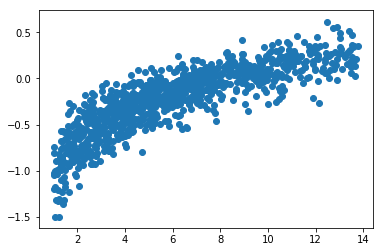

In [45]:
timesChempy = np.asarray(pars)[:,-1]
FeHChempy = np.asarray(abuns)[:,1]
MgFeChempy = np.asarray(abuns)[:,4]
sort_ind = np.argsort(timesChempy)
#plt.plot(timesChempy[sort_ind])
plt.scatter(timesChempy[sort_ind],FeHChempy[sort_ind])
#plt.xlim([9,10])

In [77]:
these_els=['C', 'Fe', 'He', 'Mg', 'N', 'Ne', 'O', 'Si']

In [82]:
t_lo = np.arange(0,13.5,0.5)
t_hi = np.arange(0.5,14.,0.5)
bin_mean=[]
bin_std=[]
TNG_bin_mean=[]
TNG_bin_std=[]
for i in range(len(t_lo)):
    cut = np.where(np.logical_and(pars[:,-1]>t_lo[i],pars[:,-1]<t_hi[i]))
    these_abs = abuns[cut]
    bin_mean.append(np.mean(these_abs,axis=0))
    bin_std.append(np.std(these_abs,axis=0))
    TNGcut = np.where(np.logical_and(timesTNG>t_lo[i],timesTNG<t_hi[i]))
    these_abs = tng.f.true_abuns[TNGcut]
    TNG_bin_mean.append(np.mean(these_abs,axis=0))
    TNG_bin_std.append(np.std(these_abs,axis=0))
bin_mean = np.asarray(bin_mean)
bin_std = np.asarray(bin_std)

# remove H
bin_mean = np.hstack([bin_mean[:,:2],bin_mean[:,3:]])
bin_std = np.hstack([bin_std[:,:2],bin_std[:,3:]])

TNG_bin_mean = np.asarray(TNG_bin_mean)
TNG_bin_std = np.asarray(TNG_bin_std)

/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:78: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/oliverphilcox/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


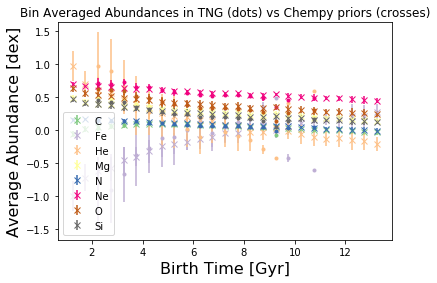

In [93]:
cols = matplotlib.cm.Accent
for e in range(len(these_els)):
    plt.errorbar(0.5*(t_lo+t_hi),bin_mean[:,e],yerr=bin_std[:,e],label=these_els[e],ls='',c=cols(float(e/len(these_els))),marker='x')
    plt.errorbar(0.5*(t_lo+t_hi),TNG_bin_mean[:,e],yerr=TNG_bin_std[:,e],ls='',c=cols(float(e/len(these_els))),marker='.')
plt.legend();
plt.xlabel('Birth Time [Gyr]',fontsize=16)
plt.ylabel('Average Abundance [dex]',fontsize=16);
plt.title('Bin Averaged Abundances in TNG (dots) vs Chempy priors (crosses)');

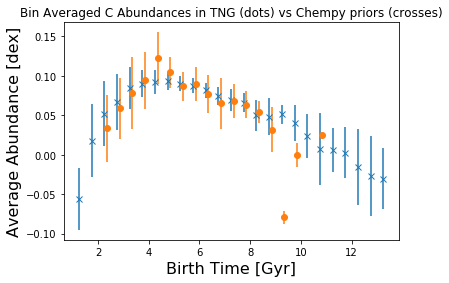

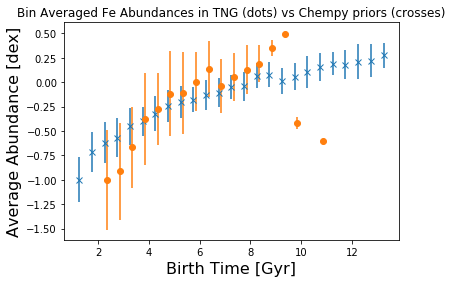

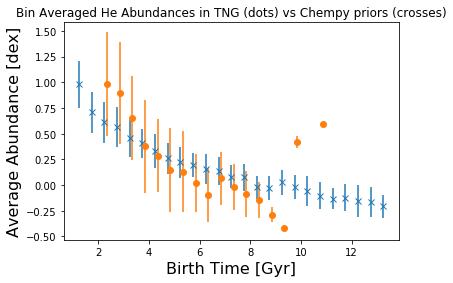

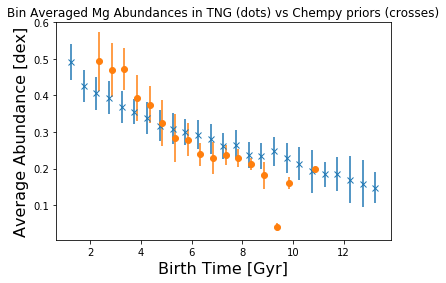

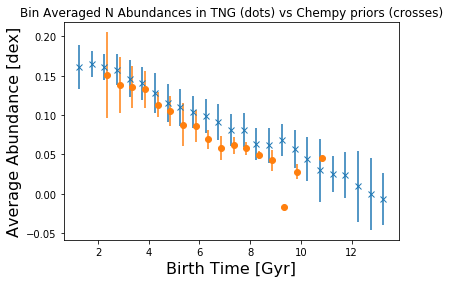

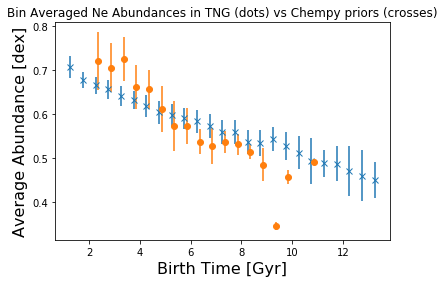

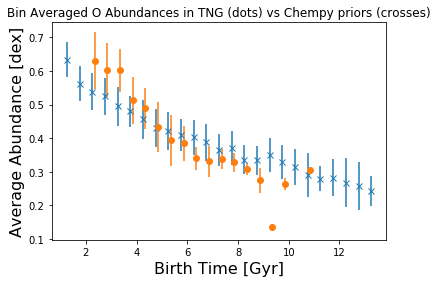

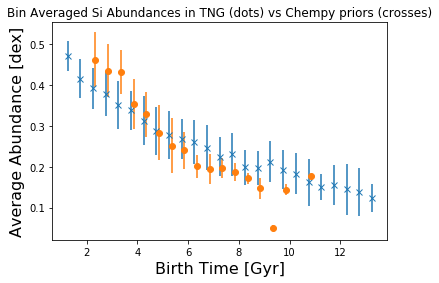

In [100]:
cols = matplotlib.cm.Accent
for e in range(len(these_els)):
    plt.figure()
    plt.errorbar(0.5*(t_lo+t_hi),bin_mean[:,e],yerr=bin_std[:,e],label=these_els[e],ls='',marker='x')
    plt.errorbar(0.1+0.5*(t_lo+t_hi),TNG_bin_mean[:,e],yerr=TNG_bin_std[:,e],ls='',marker='o')
    #plt.legend();
    plt.xlabel('Birth Time [Gyr]',fontsize=16)
    plt.ylabel('Average Abundance [dex]',fontsize=16);
    plt.title('Bin Averaged %s Abundances in TNG (dots) vs Chempy priors (crosses)'%these_els[e]);

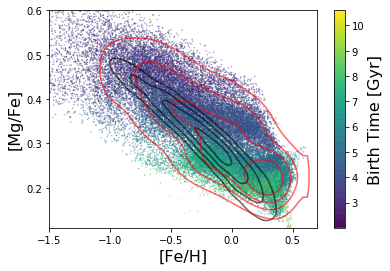

In [108]:
abuns = np.asarray(abuns)
pars = np.asarray(pars)
MgFeChempy=abuns[:,4]
HeFeChempy=abuns[:,3]#[:,4]
FeHChempy=abuns[:,1]
timesChempy=pars[:,-1]
plt.scatter(FeHTNG,MgFeTNG,alpha=0.8,s=0.1,c=timesTNG)
#plt.scatter(FeHChempy,MgFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
cohist(FeHChempy,MgFeChempy,bins=100,smooth=3.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':0.6},plot_density=False)
cohist(FeHTNG,MgFeTNG,bins=100,smooth=3.,no_fill_contours=True,plot_datapoints=False,
       contour_kwargs={'alpha':.6,'linestyles':'-','colors':'r'},plot_density=False)
cb=plt.colorbar();
cb.set_label('Birth Time [Gyr]',fontsize=FS)
plt.ylabel(r'[Mg/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
#plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1.5,0.7]);plt.ylim([0.11,0.6]);
plt.savefig('/home/oliverphilcox/ChempyMulti/Plots_New/TNG_Chempy_Comparison.pdf',bbox_inches='tight')
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

Plot abundances vs age

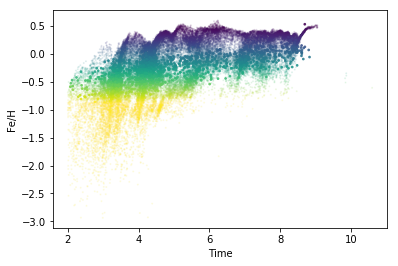

In [28]:
plt.scatter(timesTNG,FeHTNG,c=HeFeTNG,s=1,alpha=0.1)
min_, max_ = HeFeChempy.min(),HeFeChempy.max()
plt.clim([min_,max_])
plt.scatter(timesChempy,FeHChempy,c=HeFeChempy,alpha=0.8,s=3);
plt.clim([min_,max_])
#plt.ylim([-2,1.]);plt.colorbar();
plt.xlabel('Time');plt.ylabel('Fe/H');

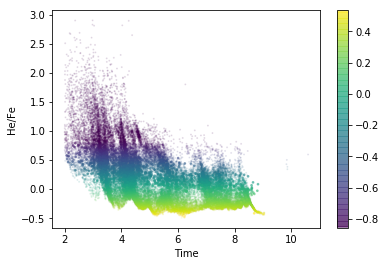

In [29]:
plt.scatter(timesTNG,HeFeTNG,c=FeHTNG,s=1,alpha=0.1)
min_, max_ = FeHChempy.min(),FeHChempy.max()
plt.clim([min_,max_])
plt.scatter(timesChempy,HeFeChempy,c=FeHChempy,s=3,alpha=0.5);
plt.clim([min_,max_])
#plt.ylim([-2,1.]);
plt.colorbar();
plt.xlabel('Time');plt.ylabel('He/Fe');

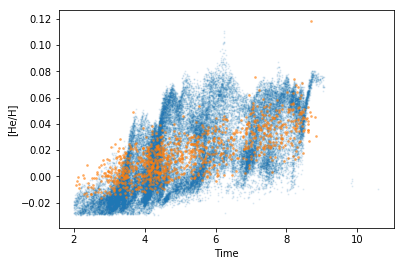

In [30]:
plt.scatter(timesTNG,HeFeTNG+FeHTNG,s=1,alpha=0.1)
plt.scatter(timesChempy,HeFeChempy+FeHChempy,s=3,alpha=0.5);
#plt.ylim([-2,1.]);
plt.xlabel('Time');plt.ylabel('[He/H]');

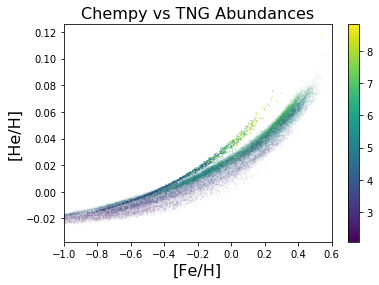

In [31]:
plt.scatter(FeHTNG,FeHTNG+HeFeTNG,alpha=0.08,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,FeHChempy+HeFeChempy,alpha=0.94,s=0.1,c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
#cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/H]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-1,0.6]);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

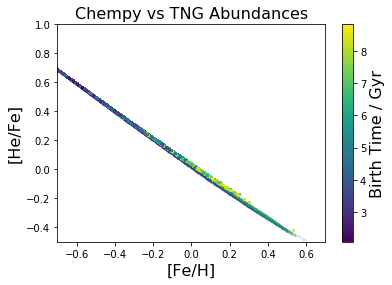

In [32]:
plt.scatter(FeHTNG,HeFeTNG,alpha=0.4,s=0.1,c=timesTNG)
plt.scatter(FeHChempy,HeFeChempy,alpha=0.94,s=4,marker='s',c=timesChempy)
from corner import hist2d as cohist
#cohist(FeHChempy,MgFeChempy,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5},plot_density=False)
#cohist(FeHTNG,MgFeTNG,bins=100,smooth=2.,no_fill_contours=True,plot_datapoints=False,
#       contour_kwargs={'alpha':0.5,'linestyles':'--','colors':'r'},plot_density=False)
cb=plt.colorbar();
cb.set_label('Birth Time / Gyr',fontsize=FS)
plt.ylabel(r'[He/Fe]',fontsize=FS);plt.xlabel(r'[Fe/H]',fontsize=FS);
plt.title('Chempy vs TNG Abundances',fontsize=FS);
plt.xlim([-0.7,0.7]);plt.ylim([-0.5,1]);
#plt.xlim([-1.1,0.6]);plt.ylim([0.1,0.5]);
#plt.xlim([-0.35,-0.21]);plt.ylim([0.2,0.4]);

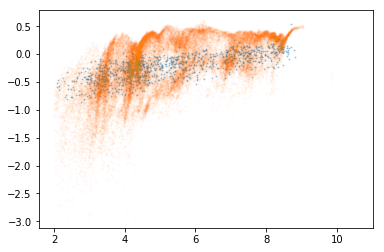

In [33]:
plt.scatter(timesChempy,FeHChempy,alpha=0.3,s=1)
plt.scatter(timesTNG,FeHTNG,alpha=0.03,s=1)

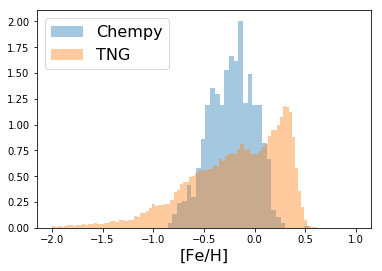

In [34]:
plt.hist(FeHChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(FeHTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[Fe/H]',fontsize=FS);plt.legend(fontsize=FS);

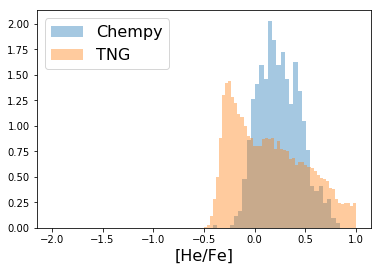

In [35]:
HeFeChempy=abuns[:,3]
plt.hist(HeFeChempy,alpha=0.4,density=True,bins=30,label='Chempy')
plt.hist(HeFeTNG,alpha=0.4,density=True,bins=100,range=[-2,1],label='TNG');
plt.xlabel('[He/Fe]',fontsize=FS);plt.legend(fontsize=FS);

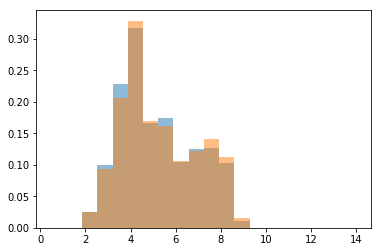

In [36]:
plt.hist(timesTNG,density=True,range=[0.5,14],bins=20,alpha=0.5);
plt.hist(timesChempy,density=True,range=[0.5,14],bins=20,alpha=0.5);